# Numerical Integration and Differentiation

This notebook illustrates how to perform numerical integration and differentiation. 

There are several packages for doing this. Here, the focus is on `QuadGK.jl` and `FiniteDiff.jl` packages. Towards the end of the notebook, there are also some (extra) comments about the `ForwardDiff.jl` and `ReverseDiff.jl` packages.

## Load Packages and Extra Functions

In [1]:
using Printf

include("jlFiles/printmat.jl");

In [2]:
using Plots
default(size = (480,320),fmt = :png)

# Numerical Integration

with the [QuadGK.jl](https://github.com/JuliaMath/QuadGK.jl) package. 

There are many alternative packages (for instance, [HCubature.jl](https://github.com/JuliaMath/HCubature.jl)), but they are not discussed in this notebook.

In [3]:
using QuadGK

## The Pdf of the N() Distribution

As a simple illustration, the next cells plot and integrate the $N(0,\sigma)$ pdf.

Notice: the function takes $\mu$ and $\sigma$ (not $\sigma^2$) as inputs, similar to the `Distributions.jl` package. 

In [4]:
function ϕNS(x,μ=0,σ=1)       #pdf of N(μ,σ), defaults to N(0,1)
    z   = (x - μ)/σ
    pdf = exp(-0.5*z^2)/(sqrt(2*pi)*σ)
    return pdf
end

ϕNS (generic function with 3 methods)

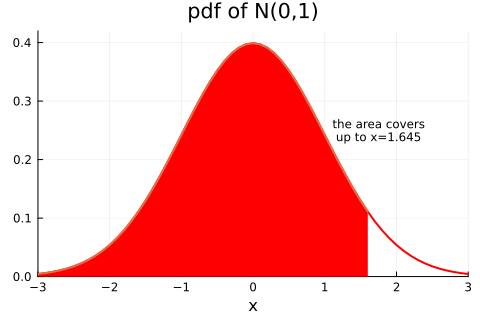

In [5]:
x  = -3:0.1:3
xb = filter(<=(1.645),x)          #same as x[x.<=1.645]

p1 = plot( x,ϕNS.(x),
           linecolor = :red,
           linewidth = 2,
           ylims = (0,0.42),
           xlims = (-3,3),
           legend = nothing,
           title = "pdf of N(0,1)",
           xlabel = "x",
           ylabel = "",
           annotation = (1.75,0.25,text("the area covers\nup to x=1.645",8)) )
plot!(xb,ϕNS.(xb),fillcolor=:red,linewidth=2,legend=nothing,fill=(0,:red))
display(p1)

## Calculating Prob(x<=1.645)

Let $\phi(x,\mu,\sigma)$ be the pdf of an $N(\mu,\sigma)$ variable. The next cell calculates

$
\displaystyle\int_{-\infty}^{1.645}\phi(x,0,\sigma)dx
$,

by numeric integration.

The input to `quadgk` should be a function with only one argument. We do that by creating an anonymous function `x->ϕNS(x,0,2)` or just `ϕNS` is we want to use the default values of the (`μ,σ`) inputs.

In [6]:
cdf1, = quadgk(ϕNS,-Inf,1.645)              #N(0,1), default values
printlnPs("\nPr(x<=1.645) according to N(0,1):", cdf1)

cdf2, = quadgk(x->ϕNS(x,0,2),-Inf,1.645)    #N(0,σ=2)
printlnPs("\nPr(x<=1.645) according to N(0,2):", cdf2)


Pr(x<=1.645) according to N(0,1):     0.950

Pr(x<=1.645) according to N(0,2):     0.795


# Numerical Derivatives

We use the [FiniteDiff.jl](https://github.com/JuliaDiff/FiniteDiff.jl) package to calculate numerical derivatives.

The `FiniteDiff.jl` package does not export its functions and the names are very long, for instance, `FiniteDiff.finite_difference_derivative`. In the next cell we therefore rename the relevant functions.

In [7]:
using FiniteDiff: finite_difference_derivative as δ, finite_difference_gradient as ∇

## A Derivative of a Function with One Input and One Output

In [8]:
function fn1(x,a)                 #a simple function, to be differentiated
   return (x - 1.1)^2 - a         #see below for a plot
end

fn1 (generic function with 1 method)

In [9]:
x₀ = 2.0
dydx_A = δ(x->fn1(x,0.5),x₀)              #make sure x₀ is a Float64

printlnPs("The derivative at x=$x₀ is: ",dydx_A)

The derivative at x=2.0 is:      1.800


In [10]:
x = -3:6/99:6          #calculate the derivative at many points

dydx_A = [δ(z->fn1(z,0.5),xᵢ) for xᵢ in x];               #xᵢ should be Float64

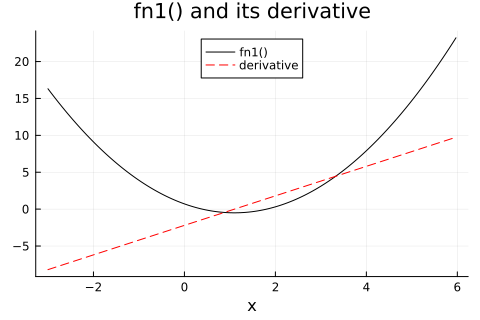

In [11]:
p1 = plot( [x x],[fn1.(x,0.5) dydx_A],
           line = [:solid :dash],
           linecolor = [:black :red],
           label = ["fn1()" "derivative"],
           legend = :top,
           title = "fn1() and its derivative",
           xlabel = "x",
           ylabel = "" )
display(p1)

## A Derivative of a Function with Many Inputs and One Output (Gradient)

In [12]:
fn2(w,Σ) = w'*Σ*w                 #a quadratic form. The derivative wrt w is 2Σw

Σ = [1 0.5
     0.5 2]
w₀ = [1.0,2.0]                   #floats

grad = ∇(z->fn2(z,Σ),w₀)

printblue("The gradient is:\n")
printmat(grad,2*Σ*w₀;colNames=["numerical","exact"])

The gradient is:

 numerical     exact
     4.000     4.000
     9.000     9.000



# Comments on Using the ForwardDiff or ReverseDiff Packages (extra)

The [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) and [ReverseDiff.jl](https://github.com/JuliaDiff/ReverseDiff.jl) packages are exact and fast. (Use the former for functions with few inputs and many outputs, and the latter for vice versa.)

However, they require that your code can handle also other types than Floats. In most cases, that is not a problem, but you may have to watch out if you create arrays to store (intermediate?) results inside the function. See the examples below.

In [13]:
using ForwardDiff: ForwardDiff.gradient as ForwardDiff_∇
using ReverseDiff: ReverseDiff.gradient as ReverseDiff_∇

In [14]:
grad_B = ForwardDiff_∇(z->fn2(z,Σ),w₀)                    #this works
grad_C = ReverseDiff_∇(z->fn2(z,Σ),w₀)

printmat(grad_B,grad_C,2*Σ*w₀;colNames=["ForwardDiff","ReverseDiff","exact"],width=15)

    ForwardDiff    ReverseDiff          exact
          4.000          4.000          4.000
          9.000          9.000          9.000



## An Illustration of the Pitfall of ForwardDiff.jl and ReverseDiff.jl

In [15]:
function fnDoesNotWork(b,a)
    z = zeros(length(b))              #will not work with ForwardDiff, since
    for i in 1:length(z)              #since z cannot store dual numbers
        z[i] = b[i]*i
    end
    return sum(z) + a
end

function fnDoesWork(b,a)
    z = similar(b)                    #will work with ForwardDiff, since
    z .= 0                            #when b is a dual number, so is z
    for i in 1:length(z)
        z[i] = b[i]*i
    end
    return sum(z) + a
end

fnDoesWork (generic function with 1 method)

In [16]:
b0 = [2]              #should be a vector for use with the gradient functions

grad_x1 = ForwardDiff_∇(b->fnDoesWork(b,1),b0)
#grad_x1 = ForwardDiff_∇(b->fnDoesNotWork(b,1),b0)    #uncomment to get an error

grad_x2 = ReverseDiff_∇(b->fnDoesWork(b,1),b0)
#grad_x2 = ReverseDiff_∇(b->fnDoesNotWork(b,1),b0)    #uncomment to get an error

printlnPs(grad_x1,grad_x2)

     1         1    
